# Detailed Workflow

This notebook walks you through a typical AutoEIS workflow, from data loading to visualization and model ranking. In summary, the steps covered in this notebook are:

- Load EIS data
- Preprocess EIS data (removing outliers, etc.)
- Generate a pool of equivalent circuit models
- Fit model parameters to the EIS data using Bayesian inference
- Rank models based on goodness-of-fit and complexity
- Visualize the results

## Set up the environment

AutoEIS relies on `EquivalentCircuits.jl` package to perform the EIS analysis. The package is not written in Python, so we need to install it first. AutoEIS ships with `julia_helpers` module that helps to install and manage Julia dependencies with minimal user interaction. For convenience, installing Julia and the required packages is done automatically when you import `autoeis` for the first time. If you have Julia installed already (discoverable in system PATH), it'll get detected and used, otherwise, it'll be installed automatically.

<div class="alert alert-info">

Note

If this is the first time you're importing AutoEIS, executing the next cell will take a while, outputting a lot of logs. Re-run the cell to get rid of the logs.

</div>

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import seaborn as sns
from IPython.display import display

import autoeis as ae

ae.visualization.set_plot_style()

# Set this to True if you're running the notebook locally
interactive = False

## Load EIS data

Once the environment is set up, we can load the EIS data. You can use [`pyimpspec`](https://vyrjana.github.io/pyimpspec/guide_data.html) to load EIS data from a variety of popular formats. Eventually, AutoEIS requires two arrays: `Z` and `freq`. `Z` is a complex impedance array, and `freq` is a frequency array. Both arrays must be 1D and have the same length. The impedance array must be in Ohms, and the frequency array must be in Hz.

For convenience, we provide a function `load_test_dataset()` in `autoeis.io` to load a test dataset. The function returns a tuple of `freq` and `Z`.

In [2]:
freq, Z = ae.io.load_test_dataset()

<div class="alert alert-info">

Note

If your EIS data is stored as text, you can easily load them using `numpy.loadtxt`. See NumPy's documentation for more details.

</div>

Now let's plot the data using AutoEIS's built-in plotting function `plot_impedance_combo`. The function takes the impedance array and the frequency array as inputs. It will plot the impedance spectrum in the Nyquist plot and the Bode plot. All plotting functions in AutoEIS can either be directly called or an `Axes` object can be passed in to specify the plotting location.

Alternatively, you can use separately call `plot_nyquist` and `plot_bode` functions to plot the Nyquist and Bode plots, in separate figures.

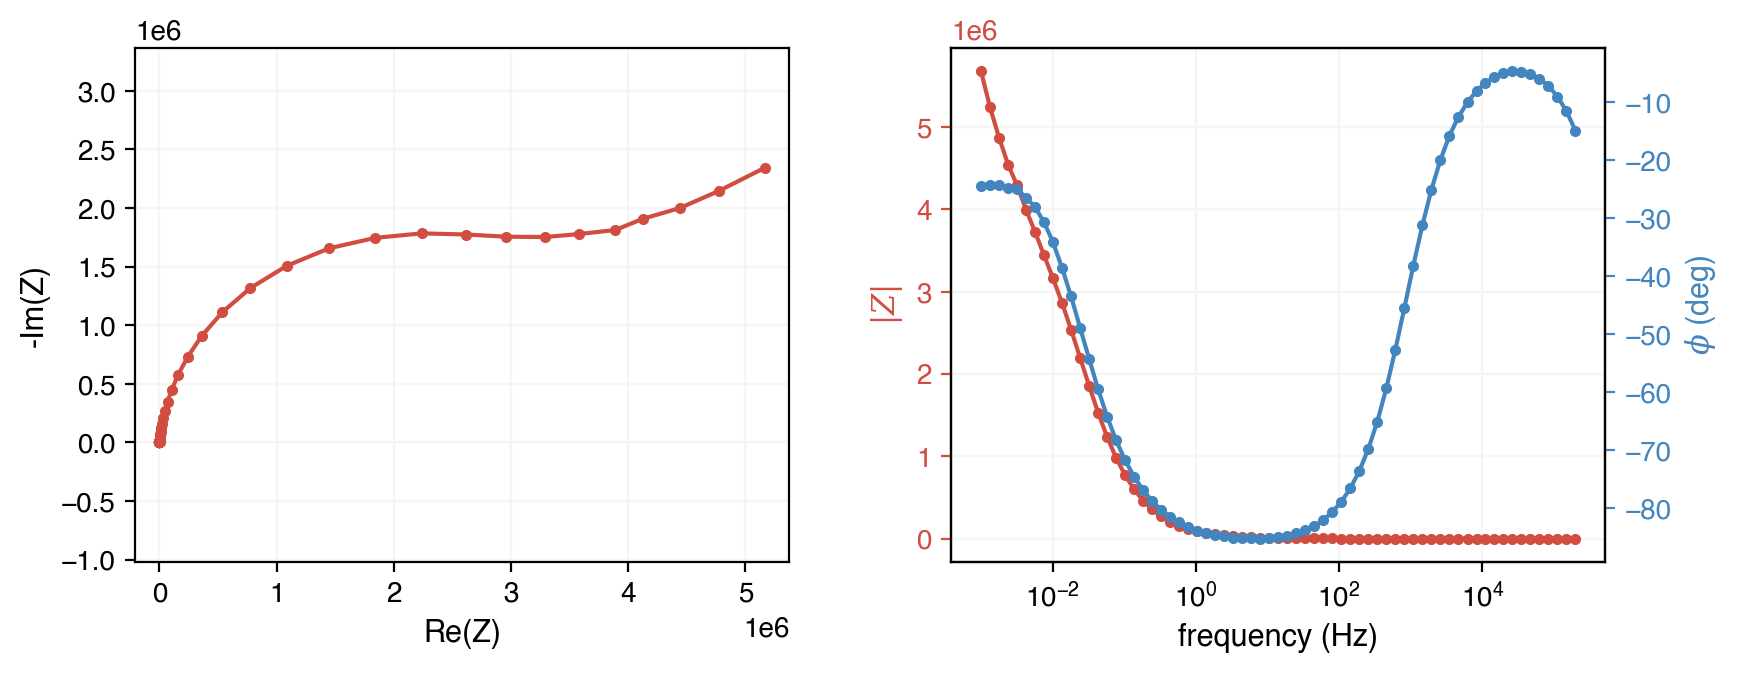

In [3]:
ax = ae.visualization.plot_impedance_combo(freq, Z)

# Alternative way to plot the EIS data
# ax = ae.visualization.plot_nyquist(Z, fmt=".")
# ax.set_title("Nyquist plot")

# ax = ae.visualization.plot_bode(freq, Z)
# ax[0].figure.suptitle("Bode plot")

<div class="alert alert-info">

Note

When plotting EIS data, much information can be lost if plotted on a linear scale (especially at high frequencies). It is recommended to plot the data on a logarithmic scale. You can do this by simply passing `log=True` to the plotting functions.

</div>

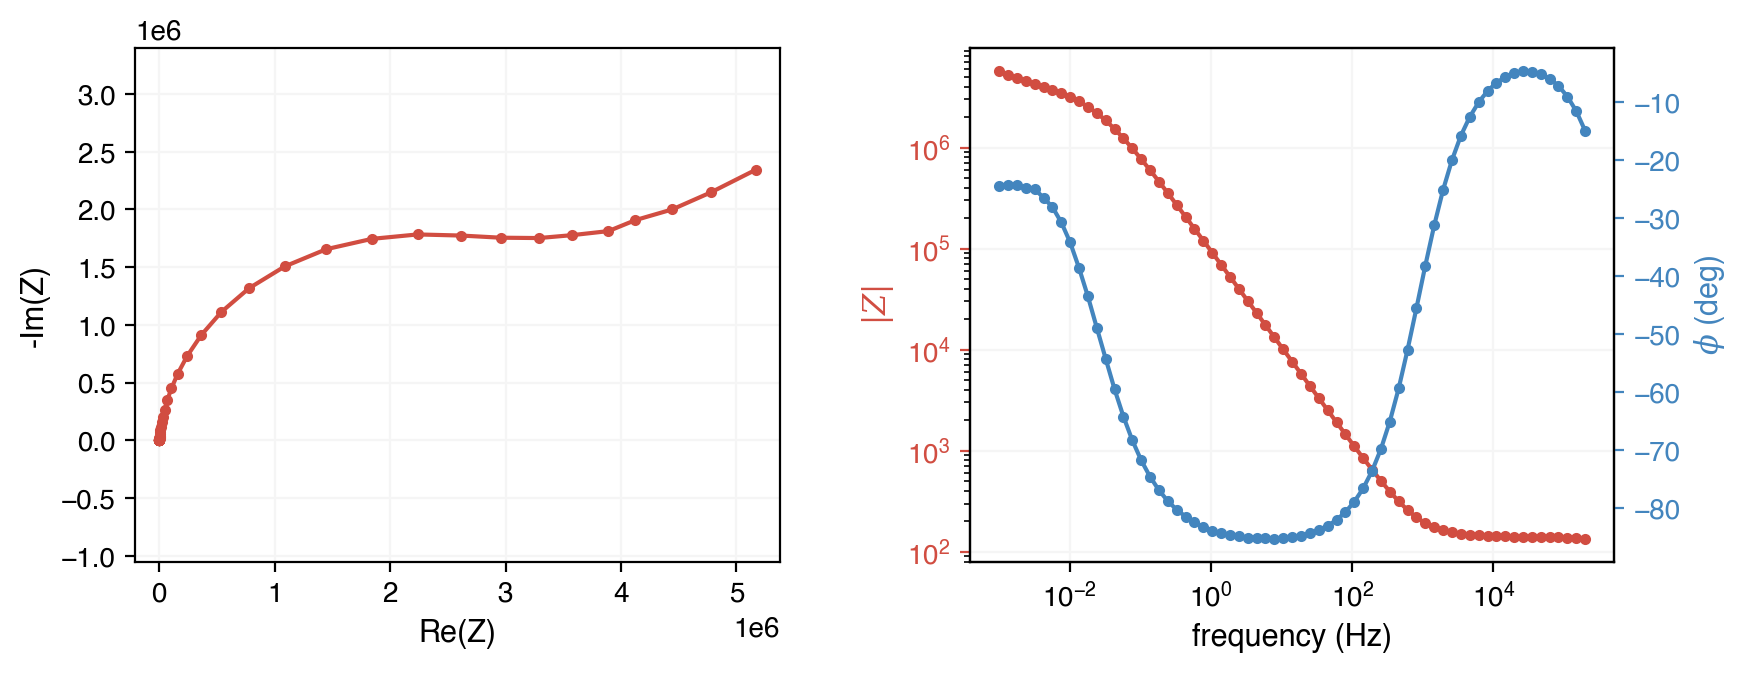

In [4]:
ax = ae.visualization.plot_impedance_combo(freq, Z, log=True)

## Preprocess impedance data
Before performing the EIS analysis, we need to preprocess the impedance data. The preprocessing step is to remove outliers. AutoEIS provides a function to perform the preprocessing. As part of the preprocessing, the impedance measurements with a positive imaginary part are removed, and the rest of the data are filtered using linear KK validation. The function returns the filtered impedance array and the frequency array.

[19:20:29] WARNING  10% of data filtered out.                                   


<Axes: title={'center': 'Lin-KK validation'}, xlabel='frequency (Hz)', ylabel='delta %'>

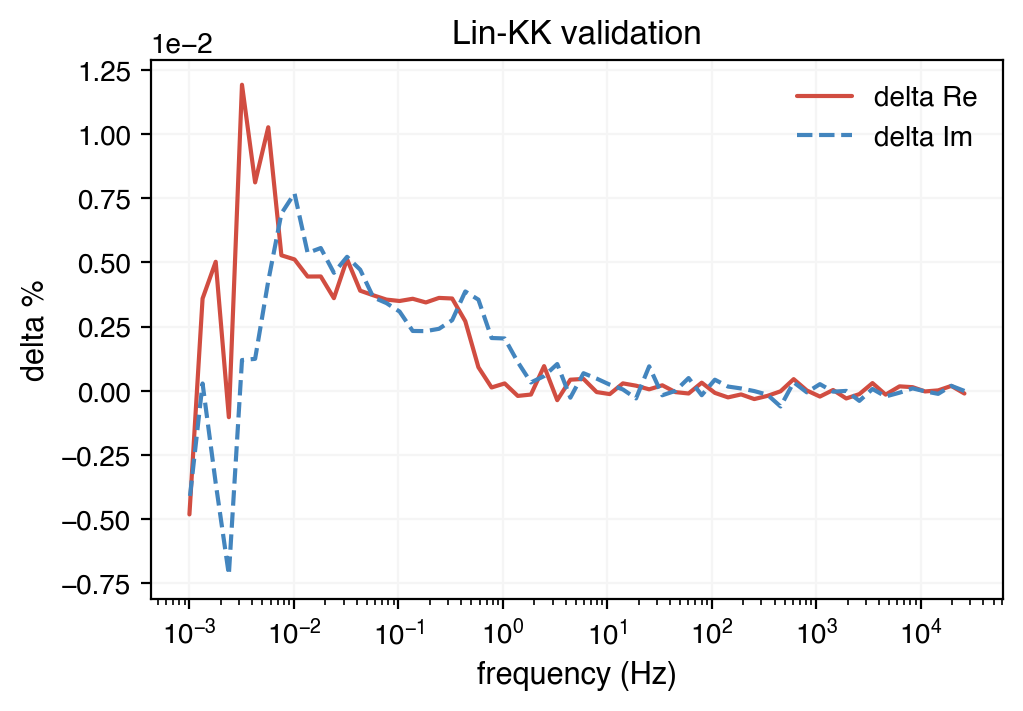

In [5]:
freq, Z, aux = ae.utils.preprocess_impedance_data(freq, Z, tol_linKK=5e-2, return_aux=True)

# NOTE: Since linKK could change `freq`, you should use `aux.freq` to plot the residuals
ae.visualization.plot_linKK_residuals(aux.freq, aux.res.real, aux.res.imag)

## Generate candidate equivalent circuits

In this stage, AutoEIS generates a list of candidate equivalent circuits using a customized genetic algorithm (done via the package `EquivalentCircuits.jl`). The function takes the filtered impedance array and the frequency array as inputs. It returns a list of candidate equivalent circuits. The function has a few optional arguments that can be used to control the number of candidate circuits and the circuit types. The default number of candidate circuits is 10, and the default circuit types are resistors, capacitors, constant phase elements, and inductors. The function runs in parallel by default, but you can turn it off by setting `parallel=false`.

<div class="alert alert-info">

Note

Since running the genetic algorithm can be time-consuming, we will use a pre-generated list of candidate circuits in this demo to get you started quickly. If you want to generate the candidate circuits yourself, set `use_pregenerated_circuits=False` in the cell below.

</div>

In [6]:
use_pregenerated_circuits = False

if use_pregenerated_circuits:
    circuits_unfiltered = ae.io.load_test_circuits()
else:
    kwargs = {
        "iters": 24,
        "complexity": 12,
        "population_size": 100,
        "generations": 30,
        "tol": 1e-3,
        "parallel": True
    }
    circuits_unfiltered = ae.core.generate_equivalent_circuits(freq, Z, **kwargs)
    # Since generating circuits is expensive, let's save the results to a CSV file
    circuits_unfiltered.to_csv("circuits_unfiltered.csv", index=False)
    # To load from file, uncomment the next 2 lines (line 2 is to convert str -> Python objects)
    # circuits_unfiltered = pd.read_csv("circuits_unfiltered.csv")
    # circuits_unfiltered["Parameters"] = circuits_unfiltered["Parameters"].apply(eval)

circuits_unfiltered

Generating Candidate ECMs:   0%|          | 0/24 [00:00<?, ?it/s]

circuitstring  \
0             [L1,R2]-[P3,L4-[P5,P6]]   
1   [R1,P2]-[[R3,L4],R5]-[P6,[P7,R8]]   
2            P1-R2-P3-[R4,P5-[R6,P7]]   
3                  [R1-P2,[R3,R4]-P5]   
4                  [P1,P2]-[R3-P4,R5]   
5            R1-[R2,P3]-L4-[P5,R6]-R7   
6                     [P1,[P2,R3]]-R4   
7                  P1-[P2,[R3,P4]]-R5   
8         P1-[P2-R3,P4-L5-P6-[L7,R8]]   
9                       [P1,P2-P3]-R4   
10                    [[R1,P2],P3]-R4   
11                 [P1-R2,P3-[L4,R5]]   
12                    [[R1,P2],P3-R4]   
13               [P1-[P2,R3],[P4,R5]]   
14            [P1-[R2,[L3,R4]-P5],R6]   
15                 [R1-P2,[R3,P4]-P5]   
16                         [P1,P2]-R3   
17                         [P1,P2]-R3   
18               [P1,P2-[[R3,L4],P5]]   
19                 R1-[P2,[P3,L4-R5]]   
20                 R1-P2-[P3,[P4,R5]]   

                                           Parameters  
0   {'L1': 4.999867315220294, 'R2': 141.9220086451...  
1   {'R1': 7722.988930344775, 'P2w': 2.40600844755...  
2   {'P1w': 1000000000.0, 'P1n': 0.927616756055439...  
3   {'R1': 140.54164949795657, 'P2w': 1.8591836471...  
4   {'P1w': 4.063179357733517e-07, 'P1n': 0.165659...  
5   {'R1': 135.90752165816133, 'R2': 3908483.37561...  
6   {'P1w': 3.97208712499766e-07, 'P1n': 0.1618281...  
7   {'P1w': 5.269454969768606e-05, 'P1n': 0.800687...  
8   {'P1w': 787319545.914619, 'P1n': 0.83677995583...  
9   {'P1w': 1.708970314212274e-06, 'P1n': 0.969080...  
10  {'R1': 999999960.8423277, 'P2w': 1.80050996590...  
11  {'P1w': 2.424552855196653e-06, 'P1n': 0.409648...  
12  {'R1': 997915380.714954, 'P2w': 4.062306743064...  
13  {'P1w': 1.7226318101901917e-06, 'P1n': 0.96567...  
14  {'P1w': 1.0137367649893007e-05, 'P1n': 0.97478...  
15  {'R1': 141.16288776069015, 'P2w': 1.8688211640...  
16  {'P1w': 4.35233690393307e-07, 'P1n': 0.1814253...  
17  {'P1w': 1.6623343709366136e-06, 'P1n': 0.97102...  
18  {'P1w': 4.133985586849051e-07, 'P1n': 0.169548...  
19  {'R1': 142.04592493535426, 'P2w': 4.0635349307...  
20  {'R1': 139.44774111624412, 'P2w': 2.7359647522...

## Filter candidate equivalent circuits

Note that all these circuits generated by the GEP process probably fit the data well, but they may not be physically meaningful. Therefore, we need to filter them to find the ones that are most plausible. AutoEIS uses "statistical plausibility" as a proxy for gauging "physical plausibility". To this end, AutoEIS provides a function to filter the candidate circuits based on some heuristics (read our [paper](https://doi.org/10.1149/1945-7111/aceab2) for the exact steps and the supporting rationale).

In [7]:
circuits = ae.core.filter_implausible_circuits(circuits_unfiltered)
# Let's save the filtered circuits to a CSV file as well
circuits.to_csv("circuits_filtered.csv", index=False)
# To load from file, uncomment the next 2 lines (line 2 is to convert str -> Python objects)
# circuits = pd.read_csv("circuits_filtered.csv")
# circuits["Parameters"] = circuits["Parameters"].apply(eval)
circuits

circuitstring                                         Parameters
0  P1-R2-P3-[R4,P5-[R6,P7]]  {'P1w': 1000000000.0, 'P1n': 0.927616756055439...
1  R1-[R2,P3]-L4-[P5,R6]-R7  {'R1': 135.90752165816133, 'R2': 3908483.37561...
2           [P1,[P2,R3]]-R4  {'P1w': 3.97208712499766e-07, 'P1n': 0.1618281...
3        P1-[P2,[R3,P4]]-R5  {'P1w': 5.269454969768606e-05, 'P1n': 0.800687...
4             [P1,P2-P3]-R4  {'P1w': 1.708970314212274e-06, 'P1n': 0.969080...
5                [P1,P2]-R3  {'P1w': 4.35233690393307e-07, 'P1n': 0.1814253...
6        R1-[P2,[P3,L4-R5]]  {'R1': 142.04592493535426, 'P2w': 4.0635349307...

## Perform Bayesian inference

Now that we have narrowed down the candidate circuits to a few good ones, we can perform Bayesian inference to find the ones that are statistically most plausible.

In [8]:
results = ae.core.perform_bayesian_inference(circuits, freq, Z)

Refining Initial Guess:   0%|          | 0/7 [00:00<?, ?it/s]

Performing Bayesian Inference:   0%|          | 0/7 [00:00<?, ?it/s]

## Visualize results

Now, let's take a look at the results. `perform_bayesian_inference` returns a list of `InferenceResult` objects. Each `InferenceResult` object contains all the information about the Bayesian inference, including the posterior distribution, the prior distribution, the likelihood function, the trace, and the summary statistics.

Before we visualize the results, let's take a look at the summary statistics. The summary statistics are the mean, the standard deviation, and the 95% credible interval of the posterior distribution. The summary statistics are useful for quickly gauging the uncertainty of the parameters.

In [9]:
for result in results:
    if result.converged:
        ae.visualization.print_summary_statistics(result.mcmc, result.circuit)

             P1-R2-P3-[R4,P5-[R6,P7]], 0/1000 divergences             
┏━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃   Parameter ┃     Mean ┃      Std ┃   Median ┃     5.0% ┃    95.0% ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│         P1n │ 5.07e-01 │ 2.86e-01 │ 5.18e-01 │ 4.92e-02 │ 9.50e-01 │
│         P1w │ 8.13e+12 │ 1.50e+14 │ 8.33e+08 │ 4.29e+05 │ 1.39e+12 │
│         P3n │ 9.32e-01 │ 2.78e-02 │ 9.30e-01 │ 8.87e-01 │ 9.81e-01 │
│         P3w │ 7.74e-05 │ 1.49e-05 │ 7.59e-05 │ 5.55e-05 │ 1.05e-04 │
│         P5n │ 9.67e-01 │ 9.17e-03 │ 9.66e-01 │ 9.53e-01 │ 9.83e-01 │
│         P5w │ 4.60e-06 │ 3.25e-07 │ 4.59e-06 │ 4.07e-06 │ 5.17e-06 │
│         P7n │ 9.44e-01 │ 4.73e-03 │ 9.44e-01 │ 9.37e-01 │ 9.53e-01 │
│         P7w │ 3.24e-06 │ 1.78e-07 │ 3.22e-06 │ 2.97e-06 │ 3.56e-06 │
│          R2 │ 1.41e+02 │ 6.08e-01 │ 1.41e+02 │ 1.40e+02 │ 1.42e+02 │
│          R4 │ 5.01e+06 │ 1.43e+05 │ 5.01e+06 │ 4.76e+06 │ 5.24e+06 │
│          R6 │ 3.38e+06 │ 2.94e+05 │ 3.39e+06 │ 2.89e+06 │ 3.84e+06 │
│   sigma.mag │ 6.23e-03 │ 6.42e-04 │ 6.17e-03 │ 5.31e-03 │ 7.42e-03 │
│ sigma.phase │ 1.51e-02 │ 1.52e-03 │ 1.50e-02 │ 1.29e-02 │ 1.78e-02 │
└─────────────┴──────────┴──────────┴──────────┴──────────┴──────────┘

            R1-[R2,P3]-L4-[P5,R6]-R7, 10/1000 divergences             
┏━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃   Parameter ┃     Mean ┃      Std ┃   Median ┃     5.0% ┃    95.0% ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│          L4 │ 2.45e-09 │ 1.96e-08 │ 1.72e-12 │ 6.26e-16 │ 1.83e-09 │
│         P3n │ 9.52e-01 │ 2.19e-03 │ 9.52e-01 │ 9.49e-01 │ 9.56e-01 │
│         P3w │ 2.04e-06 │ 2.06e-08 │ 2.04e-06 │ 2.01e-06 │ 2.08e-06 │
│         P5n │ 9.26e-01 │ 1.54e-02 │ 9.24e-01 │ 9.04e-01 │ 9.53e-01 │
│         P5w │ 2.26e-05 │ 2.29e-06 │ 2.23e-05 │ 1.94e-05 │ 2.66e-05 │
│          R1 │ 2.91e-01 │ 6.84e-01 │ 1.48e-02 │ 7.65e-06 │ 1.86e+00 │
│          R2 │ 3.14e+06 │ 6.83e+04 │ 3.14e+06 │ 3.04e+06 │ 3.26e+06 │
│          R6 │ 4.48e+06 │ 2.22e+05 │ 4.49e+06 │ 4.11e+06 │ 4.84e+06 │
│          R7 │ 1.40e+02 │ 1.06e+00 │ 1.40e+02 │ 1.38e+02 │ 1.42e+02 │
│   sigma.mag │ 9.05e-03 │ 8.59e-04 │ 9.01e-03 │ 7.70e-03 │ 1.05e-02 │
│ sigma.phase │ 1.91e-02 │ 1.80e-03 │ 1.90e-02 │ 1.64e-02 │ 2.23e-02 │
└─────────────┴──────────┴──────────┴──────────┴──────────┴──────────┘

                 [P1,[P2,R3]]-R4, 2/1000 divergences                  
┏━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃   Parameter ┃     Mean ┃      Std ┃   Median ┃     5.0% ┃    95.0% ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│         P1n │ 9.61e-01 │ 9.23e-04 │ 9.61e-01 │ 9.60e-01 │ 9.63e-01 │
│         P1w │ 1.75e-06 │ 8.05e-09 │ 1.75e-06 │ 1.74e-06 │ 1.77e-06 │
│         P2n │ 1.56e-01 │ 3.77e-03 │ 1.55e-01 │ 1.50e-01 │ 1.62e-01 │
│         P2w │ 3.92e-07 │ 5.69e-09 │ 3.92e-07 │ 3.83e-07 │ 4.01e-07 │
│          R3 │ 9.15e+16 │ 1.90e+18 │ 7.00e+12 │ 9.65e+09 │ 1.64e+16 │
│          R4 │ 1.42e+02 │ 5.70e-01 │ 1.42e+02 │ 1.41e+02 │ 1.43e+02 │
│   sigma.mag │ 5.54e-03 │ 6.22e-04 │ 5.48e-03 │ 4.64e-03 │ 6.59e-03 │
│ sigma.phase │ 2.64e-02 │ 2.67e-03 │ 2.62e-02 │ 2.24e-02 │ 3.10e-02 │
└─────────────┴──────────┴──────────┴──────────┴──────────┴──────────┘

                P1-[P2,[R3,P4]]-R5, 5/1000 divergences                
┏━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃   Parameter ┃     Mean ┃      Std ┃   Median ┃     5.0% ┃    95.0% ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│         P1n │ 8.11e-01 │ 9.37e-03 │ 8.10e-01 │ 7.96e-01 │ 8.28e-01 │
│         P1w │ 5.40e-05 │ 3.07e-06 │ 5.39e-05 │ 4.92e-05 │ 5.93e-05 │
│         P2n │ 1.30e-01 │ 2.87e-03 │ 1.30e-01 │ 1.25e-01 │ 1.35e-01 │
│         P2w │ 3.91e-07 │ 3.88e-09 │ 3.91e-07 │ 3.85e-07 │ 3.98e-07 │
│         P4n │ 9.68e-01 │ 1.42e-03 │ 9.68e-01 │ 9.66e-01 │ 9.71e-01 │
│         P4w │ 1.83e-06 │ 6.51e-09 │ 1.83e-06 │ 1.82e-06 │ 1.84e-06 │
│          R3 │ 2.19e+14 │ 2.62e+15 │ 1.27e+11 │ 1.13e+09 │ 2.10e+14 │
│          R5 │ 1.41e+02 │ 3.77e-01 │ 1.41e+02 │ 1.40e+02 │ 1.41e+02 │
│   sigma.mag │ 2.87e-03 │ 3.24e-04 │ 2.83e-03 │ 2.39e-03 │ 3.45e-03 │
│ sigma.phase │ 1.19e-02 │ 1.28e-03 │ 1.19e-02 │ 1.01e-02 │ 1.42e-02 │
└─────────────┴──────────┴──────────┴──────────┴──────────┴──────────┘

                  [P1,P2-P3]-R4, 0/1000 divergences                   
┏━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃   Parameter ┃     Mean ┃      Std ┃   Median ┃     5.0% ┃    95.0% ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│         P1n │ 9.56e-01 │ 4.54e-04 │ 9.56e-01 │ 9.55e-01 │ 9.57e-01 │
│         P1w │ 1.81e-06 │ 4.46e-09 │ 1.81e-06 │ 1.80e-06 │ 1.81e-06 │
│         P2n │ 5.46e-02 │ 1.24e-02 │ 5.56e-02 │ 3.49e-02 │ 7.26e-02 │
│         P2w │ 3.50e-07 │ 4.82e-09 │ 3.49e-07 │ 3.43e-07 │ 3.59e-07 │
│         P3n │ 5.09e-01 │ 3.86e-02 │ 5.09e-01 │ 4.46e-01 │ 5.72e-01 │
│         P3w │ 5.77e-06 │ 1.72e-06 │ 5.52e-06 │ 3.47e-06 │ 8.74e-06 │
│          R4 │ 1.41e+02 │ 2.29e-01 │ 1.41e+02 │ 1.41e+02 │ 1.42e+02 │
│   sigma.mag │ 2.18e-03 │ 2.15e-04 │ 2.17e-03 │ 1.84e-03 │ 2.57e-03 │
│ sigma.phase │ 1.17e-02 │ 1.12e-03 │ 1.16e-02 │ 1.01e-02 │ 1.38e-02 │
└─────────────┴──────────┴──────────┴──────────┴──────────┴──────────┘

                    [P1,P2]-R3, 0/1000 divergences                    
┏━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃   Parameter ┃     Mean ┃      Std ┃   Median ┃     5.0% ┃    95.0% ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│         P1n │ 9.61e-01 │ 9.19e-04 │ 9.61e-01 │ 9.60e-01 │ 9.63e-01 │
│         P1w │ 1.75e-06 │ 8.29e-09 │ 1.75e-06 │ 1.74e-06 │ 1.76e-06 │
│         P2n │ 1.56e-01 │ 3.87e-03 │ 1.56e-01 │ 1.50e-01 │ 1.62e-01 │
│         P2w │ 3.92e-07 │ 5.71e-09 │ 3.92e-07 │ 3.83e-07 │ 4.01e-07 │
│          R3 │ 1.42e+02 │ 5.69e-01 │ 1.42e+02 │ 1.41e+02 │ 1.43e+02 │
│   sigma.mag │ 5.52e-03 │ 5.70e-04 │ 5.49e-03 │ 4.62e-03 │ 6.52e-03 │
│ sigma.phase │ 2.64e-02 │ 2.69e-03 │ 2.61e-02 │ 2.24e-02 │ 3.11e-02 │
└─────────────┴──────────┴──────────┴──────────┴──────────┴──────────┘

                R1-[P2,[P3,L4-R5]], 0/1000 divergences                
┏━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃   Parameter ┃     Mean ┃      Std ┃   Median ┃     5.0% ┃    95.0% ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│          L4 │ 1.19e+04 │ 2.28e+05 │ 4.37e+00 │ 2.83e-03 │ 1.09e+04 │
│         P2n │ 1.55e-01 │ 3.52e-03 │ 1.55e-01 │ 1.49e-01 │ 1.61e-01 │
│         P2w │ 3.91e-07 │ 5.23e-09 │ 3.91e-07 │ 3.82e-07 │ 4.00e-07 │
│         P3n │ 9.61e-01 │ 8.65e-04 │ 9.61e-01 │ 9.60e-01 │ 9.63e-01 │
│         P3w │ 1.75e-06 │ 7.62e-09 │ 1.75e-06 │ 1.74e-06 │ 1.77e-06 │
│          R1 │ 1.42e+02 │ 5.63e-01 │ 1.42e+02 │ 1.41e+02 │ 1.43e+02 │
│          R5 │ 5.94e+17 │ 7.77e+18 │ 2.68e+14 │ 1.38e+11 │ 6.15e+17 │
│   sigma.mag │ 5.48e-03 │ 5.34e-04 │ 5.43e-03 │ 4.66e-03 │ 6.42e-03 │
│ sigma.phase │ 2.66e-02 │ 2.53e-03 │ 2.65e-02 │ 2.28e-02 │ 3.12e-02 │
└─────────────┴──────────┴──────────┴──────────┴──────────┴──────────┘

Note that some rows have been highlighted in yellow, indicating that the standard deviation is greater than the mean. This is not necessarily a bad thing, but it screams "caution" due to the high uncertainty. In this case, we need to check the data and the model to see if there is anything wrong. For example, the data may contain outliers, or the model may be overparameterized.

Before we investigate the posteriors for individual circuit components for each circuit, let's take a bird's eye view of the results, so you have a general feeling about which circuits are generally better, and which ones are worse. For this purpose, we first need to evaluate the circuits based on some common metrics, and then rank them accordingly:

In [10]:
# We first need to augment the circuits dataframe with MCMC results
circuits["InferenceResult"] = results

# Now, we can compute the fitness metrics, then rank/visualize accordingly
circuits = ae.core.compute_fitness_metrics(circuits, freq, Z)
ae.visualization.print_inference_results(circuits)

                                            Inference results                                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━┓
┃                  Circuit ┃ WAIC (mag) ┃ WAIC (phase) ┃ R2 (re) ┃ R2 (im) ┃ MAPE (re) ┃ MAPE (im) ┃ Np ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━┩
│            [P1,P2-P3]-R4 │  -6.25e+02 │    -3.56e+02 │   1.000 │   0.999 │  4.21e+00 │  3.87e+00 │  7 │
│       P1-[P2,[R3,P4]]-R5 │  -5.84e+02 │    -3.49e+02 │   1.000 │   0.998 │  4.35e+00 │  3.77e+00 │  8 │
│ P1-R2-P3-[R4,P5-[R6,P7]] │  -4.93e+02 │    -3.23e+02 │   0.999 │   0.997 │  6.24e+00 │  4.49e+00 │ 11 │
│       R1-[P2,[P3,L4-R5]] │  -5.14e+02 │    -2.52e+02 │   0.999 │   0.973 │  9.40e+00 │  6.31e+00 │  7 │
│          [P1,[P2,R3]]-R4 │  -5.13e+02 │    -2.52e+02 │   0.999 │   0.974 │  9.33e+00 │  6.29e+00 │  6 │
│               [P1,P2]-R3 │  -5.10e+02 │    -2.52e+02 │   0.999 │   0.974 │  9.33e+00 │  6.30e+00 │  5 │
│ R1-[R2,P3]-L4-[P5,R6]-R7 │  -4.61e+02 │    -2.82e+02 │   0.997 │   0.995 │  8.14e+00 │  5.13e+00 │  9 │
└──────────────────────────┴────────────┴──────────────┴─────────┴─────────┴───────────┴───────────┴────┘

Now, let's take one step further and visualize the results. To get an overview of the results, we can plot the posterior distributions of the parameters as well as the trace plots. It's an oversimplification, but basically, a good posterior distribution should be unimodal and symmetric, and the trace plot should be stationary. In probabilistic terms, this means that given the circuit model, the data are informative about the parameters, and the MCMC algorithm has converged. 

On the other hand, if the posterior distribution is multimodal or skewed, or the trace plot is not stationary, it means that the data are not informative about the parameters, and the MCMC algorithm has not converged. In this case, we need to check the data and the model to see if there is anything wrong. For example, the data may contain outliers, or the model may be overparameterized.

<div class="alert alert-info">

Note

For the following cell to work, you need to set `interactive=True` at the beginning of the notebook. It's turned off by default since GitHub doesn't render interactive plots.

</div>

In [11]:
def plot_trace(samples):
    """Plots the posterior and trace of a variable in the MCMC sampler."""
    output = widgets.Output()
    with output:
        fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
        log_scale = bool(np.std(samples) / np.median(samples) > 2)
        kwargs_hist = {
            "stat": "density",
            "log_scale": log_scale,
            "color": "lightblue",
            "bins": 25,
        }
        # ax[0] -> posterior, ax[1] -> trace
        sns.histplot(samples, **kwargs_hist, ax=ax[0])
        kwargs_kde = {"log_scale": log_scale, "color": "red"}
        sns.kdeplot(samples, **kwargs_kde, ax=ax[0])
        # Plot trace
        ax[1].plot(samples, alpha=0.5)
        ax[1].set_yscale("log" if log_scale else "linear")
        plt.show(fig)
    return output


def plot_trace_all(mcmc: "numpyro.MCMC", circuit: str):
    """Plots the posterior and trace of all variables in the MCMC sampler."""
    variables = ae.parser.get_parameter_labels(circuit)
    samples = mcmc.get_samples()
    children = [plot_trace(samples[var]) for var in variables]
    tab = widgets.Tab()
    tab.children = children
    tab.titles = variables
    return tab


def dropdown_trace_plots():
    """Creates a dropdown menu to select a circuit and plot its trace."""

    def on_dropdown_clicked(change):
        with output:
            output.clear_output()
            idx = circuits_list.index(change.new)
            plot = trace_plots[idx]
            display(plot)

    dropdown = widgets.Dropdown(
        description="Circuit:", options=circuits_list, value=circuits_list[0]
    )
    output = widgets.Output()
    dropdown.observe(on_dropdown_clicked, names="value")
    display(dropdown, output)

    # Default to the first circuit
    with output:
        display(trace_plots[0])


# Cache rendered plots to avoid re-rendering
circuits_list = circuits["circuitstring"].tolist()
trace_plots = []

for i, row in circuits.iterrows():
    circuit = row["circuitstring"]
    mcmc = row["InferenceResult"].mcmc
    if row["converged"]:
        trace_plots.append(plot_trace_all(mcmc, circuit))
    else:
        trace_plots.append("Inference failed")

if interactive:
    dropdown_trace_plots()

The functions defined in the above cell are used to make the interactive dropdown menu. The dropdown menu lets you select a circuit model, and shows the posterior distributions of the parameters as well as the trace plots. The dropdown menu is useful for quickly comparing the results of different circuit models. Running this cell for the first time may take a while (~ 5 seconds per circuit), but once run, all the plots will be cached.

The distributions for the most part look okay, although in some cases (like R2 and R4 in the first circuit) the span is quite large (~ few orders of magnitude). Nevertheless, the distributions are bell-shaped. The trace plots also look stationary.

Now, let's take a look at the posterior predictive distributions. "Posterior predictive" is a fancy term for "model prediction", meaning that after we have performed Bayesian inference, we can use the posterior distribution to make predictions. In this case, we can use the posterior distribution to predict the impedance spectrum and compare it with our measurements and see how well they match. After all, all the posteriors might look good (bell-shaped, no multimodality, etc.) but if the model predictions don't match the data, then the model is not good.

<div class="alert alert-info">

Note

For the following cell to work, you need to set `interactive=True` at the beginning of the notebook. It's turned off by default since GitHub doesn't render interactive plots.

</div>

In [12]:
def plot_nyquist(mcmc: "numpyro.MCMC", circuit: str):
    """Plots Nyquist plot of the circuit using the median of the posteriors."""
    # Compute circuit impedance using median of posteriors
    samples = mcmc.get_samples()
    variables = ae.parser.get_parameter_labels(circuit)
    percentiles = [10, 50, 90]
    params_list = [[np.percentile(samples[v], p) for v in variables] for p in percentiles]
    circuit_fn = ae.utils.generate_circuit_fn(circuit)
    Zsim_list = [circuit_fn(freq, params) for params in params_list]
    # Plot Nyquist plot
    fig, ax = plt.subplots(figsize=(5.5, 4))
    for p, Zsim in zip(percentiles, Zsim_list):
        ae.visualization.plot_nyquist(Zsim, fmt="-", label=f"model ({p}%)", ax=ax)
    ae.visualization.plot_nyquist(Z, fmt="o", label="measured", ax=ax)
    # Next line is necessary to avoid plotting the first time
    plt.close(fig)
    return fig


def dropdown_nyquist_plots():
    """Creates a dropdown menu to select a circuit and plot its Nyquist plot."""

    def on_change(change):
        with output:
            output.clear_output()
            idx = circuits_list.index(change.new)
            fig = nyquist_plots[idx]
            display(fig)

    output = widgets.Output()
    dropdown = widgets.Dropdown(
        options=circuits_list, value=circuits_list[0], description="Circuit:"
    )
    dropdown.observe(on_change, names="value")
    display(dropdown, output)

    # Default to the first circuit
    with output:
        display(nyquist_plots[0])


# Cache rendered plots to avoid re-rendering
circuits_list = circuits["circuitstring"].tolist()
nyquist_plots = []

for i, row in circuits.iterrows():
    circuit = row["circuitstring"]
    mcmc = row["InferenceResult"].mcmc
    if row["converged"]:
        nyquist_plots.append(plot_nyquist(mcmc, circuit))
    else:
        nyquist_plots.append("Inference failed")

if interactive:
    dropdown_nyquist_plots()

/Users/runner/work/AutoEIS/AutoEIS/src/autoeis/visualization.py:160: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "o" (-> color=(0.8549019607843137, 0.4392156862745098, 0.17254901960784313, 1)). The keyword argument will take precedence.
  ax.plot(Z.real, -Z.imag, fmt, c=color, markersize=markersize, label=label, alpha=alpha)
